In [ ]:
# import libraries

import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report, confusion_matrix

In [ ]:
# link the drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# the data schema
fpath = "/content/gdrive/MyDrive/mydatasets/PlantVillage/PlantVillage"
# read the directories names inside PlantVillage as class names
name_class = os.listdir(fpath)
name_class

['Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Target_Spot',
 'Tomato_Late_blight',
 'Tomato_healthy',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Leaf_Mold',
 'Tomato_Early_blight',
 'Potato___Early_blight',
 'Pepper__bell___healthy',
 'Tomato_Bacterial_spot',
 'Potato___Late_blight',
 'Potato___healthy',
 'Pepper__bell___Bacterial_spot']

In [ ]:
# read all images paths from all the directories inside PlantVillage
filepaths = list(glob.glob(fpath+'/**/*.*'))

In [ ]:
# extract the images labels from their paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) 

# transform the filepaths list into a pandas series 
filepath = pd.Series(filepaths, name='Filepath').astype(str)

# transform the labels list into a pandas series
labels = pd.Series(labels, name='Label')

# create dataframe
data = pd.concat([filepath, labels], axis=1)

# reset_index method set a column of index in the data
data = data.sample(frac=1).reset_index(drop=True) 

# read the first 5 rows
data.head(5)


,Filepath,Label
0,/content/gdrive/MyDrive/mydatasets/PlantVillag...,Tomato_Late_blight
1,/content/gdrive/MyDrive/mydatasets/PlantVillag...,Tomato_Spider_mites_Two_spotted_spider_mite
2,/content/gdrive/MyDrive/mydatasets/PlantVillag...,Tomato__Target_Spot
3,/content/gdrive/MyDrive/mydatasets/PlantVillag...,Tomato__Tomato_YellowLeaf__Curl_Virus
4,/content/gdrive/MyDrive/mydatasets/PlantVillag...,Tomato_Bacterial_spot


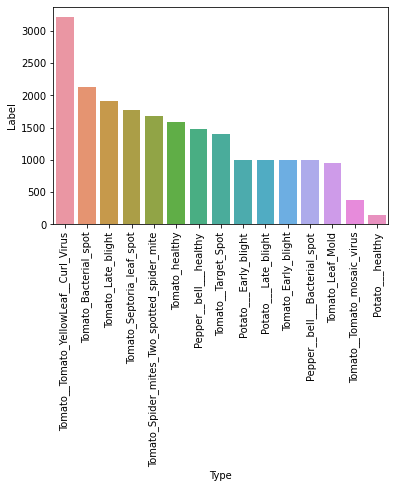

In [ ]:
# count the labels
counts = data.Label.value_counts() 

# plot an histogram of the labels
sns.barplot(x=counts.index, y=counts) 
plt.xlabel('Type')

# rotate the labels names
plt.xticks(rotation=90);

In [ ]:
# split the data into train and test
train, test = train_test_split(data, test_size=0.25, random_state=42)

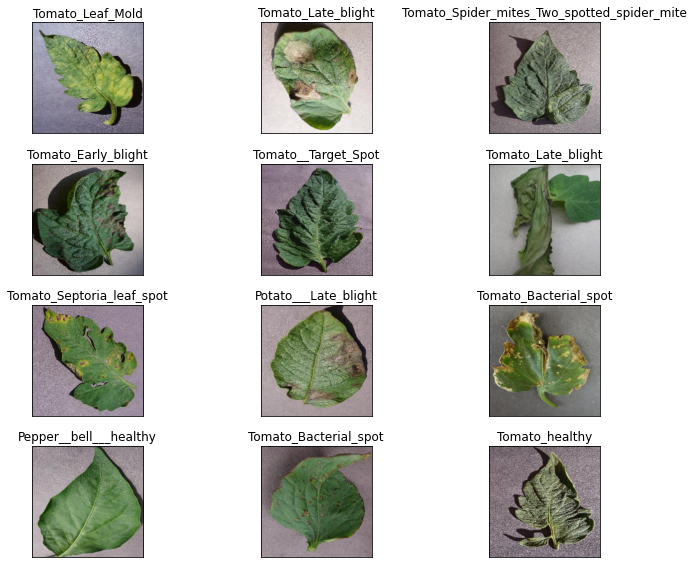

In [ ]:
# initialize a figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})

# plot randomly 12 image
from random import randint
for i, ax in enumerate(axes.flat):
    # read a random int between [0,len(data.Filepath : "column")] 
    r = randint(0,len(data.Filepath)) 
    # read the image and plot it
    ax.imshow(plt.imread(data.Filepath[r]))
    ax.set_title(data.Label[r])
plt.tight_layout()
plt.show()

In [ ]:
# initialize augmentation objects for train, valid and test data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2) 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 

In [ ]:
# read the train images from train data and apply the augmentation
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    # set the input image size
    target_size=(224,224),
    # set the classification mode
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
) 

# read the validation images from train data and apply the augmentation
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42
)
# read the test images from test data and apply the augmentation
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 15478 validated image filenames belonging to 15 classes.
Found 15478 validated image filenames belonging to 15 classes.
Found 5160 validated image filenames belonging to 15 classes.


In [ ]:
# initialize the pretrained model ResNet50
pretrained_model = ResNet50(
    # specify the input shape
    input_shape=(224,224, 3),
    # do not load the last fully connected layers
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
# set trainable parameter to False to kill the training on the weights 
pretrained_model.trainable = False


In [ ]:
# adding the last layers to the pretrained model

# import the last fully connected layers of ResNet50
inputs = pretrained_model.input

# add 2 dense layer 
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(64, activation='relu')(x)

# the output is a fully dense layer with softmax for classification
outputs = Dense(15, activation='softmax')(x)

# initialize the model
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# use adam as an optimizer and categorical_crossentropy for the loss 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
# to stop the training if there is a decrement in the val_accuracy value
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [ ]:
history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

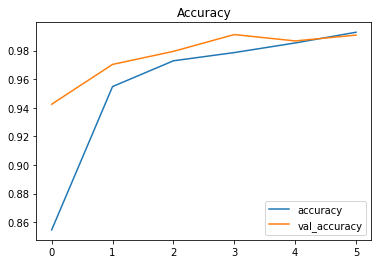

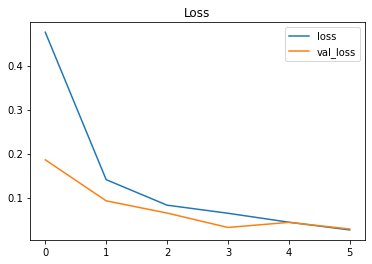

In [ ]:
# plot the accuracy of valid and train set
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# plot the loss of the validation and train set
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# evaluate the model on the test set
# set verbose to 0 to not show the details
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11311
Test Accuracy: 96.51%


In [ ]:
# Predict the labels of the test set
pred = model.predict(test_gen)

# take the index of the maximum probability
pred = np.argmax(pred,axis=1) 

# class_indices is a dict contain the class names as keys and class indices as value
labels = (train_gen.class_indices)

# inverse the keys and values in dict labels
labels = dict((v,k) for k,v in labels.items())

# transform the predicted indices to label names
pred = [labels[k] for k in pred]

In [ ]:
# put the true test labels in y_test 
y_test = list(test.Label)

# create a classification report
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       248
                     Pepper__bell___healthy       0.98      1.00      0.99       404
                      Potato___Early_blight       1.00      0.98      0.99       246
                       Potato___Late_blight       0.96      0.98      0.97       252
                           Potato___healthy       0.97      0.88      0.92        34
                      Tomato_Bacterial_spot       1.00      0.98      0.99       483
                        Tomato_Early_blight       0.93      0.92      0.92       238
                         Tomato_Late_blight       0.95      0.96      0.95       464
                           Tomato_Leaf_Mold       0.86      1.00      0.92       246
                  Tomato_Septoria_leaf_spot       0.99      0.94      0.97       467
Tomato_Spider_mites_Two_spotted_spider_mite       0.92      0.97

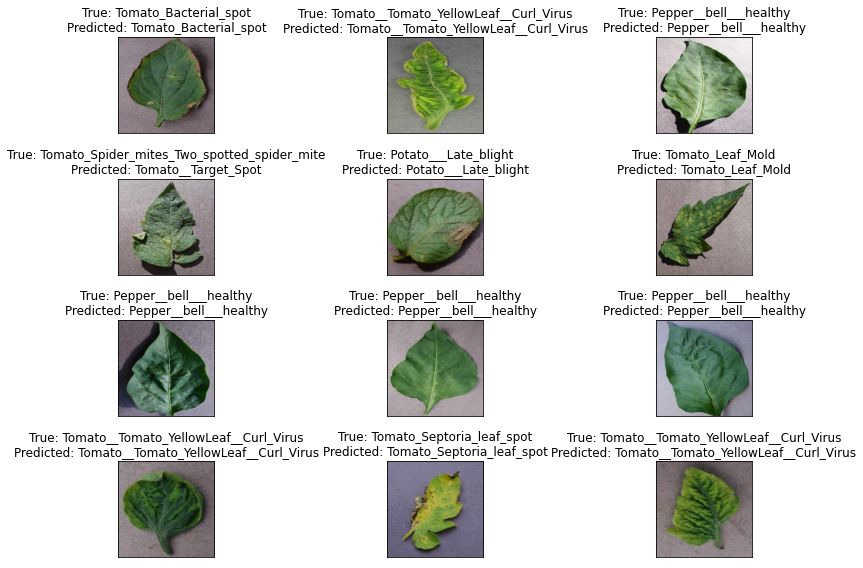

In [ ]:
# plot 12 random images with true and pred label from test set
from random import randint
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    r = randint(0,1000)
    ax.imshow(plt.imread(test.Filepath.iloc[r]))
    ax.set_title(f"True: {test.Label.iloc[r]}\nPredicted: {pred[r]}")
plt.tight_layout()
plt.show()